In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress, interactive
from IPython.display import display
from joblib import Parallel, delayed
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, PSF_residuals
import sys
%config InlineBackend.figure_format = 'retina'

# Read in datacube, assign data and header, setup variables for continuous use throughout notebook

In [2]:
#Open Fits file and assign to raw_data
hdulist = fits.open("FCC170_data/FCC170_OIII_center_cube.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]
wavelength = np.exp(hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3'])
# swap axes to y,x,wavelength
raw_data_list = np.array(raw_data).reshape(len(wavelength), x_data*y_data)
raw_data_list = np.swapaxes(raw_data_list, 1, 0)
# Check for nan values
raw_data_list[np.isnan(raw_data_list)]=0.001
raw_data_cube = raw_data_list.reshape(y_data, x_data, len(wavelength))

# Read in x and y coordinates
x_y_list = np.load("exported_data/FCC170/x_y_list_cen.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

n_pixels = 13
z = 0.005751
c = 299792458.0

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

flatten = lambda l: [item for sublist in l for item in sublist]

# Retrieve the respective spectra for each PNe source
PNe_spectra = np.array([PNextractor(x, y, n_pixels, raw_data_cube, wave=wavelength, dim=2.0) for x,y in zip(x_PNe, y_PNe)])

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error", "A/rN"))
PNe_df["PNe number"] = np.arange(1,len(x_PNe)+1)
# .loc(Row, column name)

#construct error cube
error_cube = np.zeros((len(x_PNe), n_pixels**2, len(wavelength)))
for PNe_num in np.arange(0, len(x_PNe)):
    list_of_std = [np.abs(np.std(spec)) for spec in PNe_spectra[PNe_num]]
    error_cube[PNe_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

# 3D fitting routine

$$ f(x,y) = A \Big(1+ \frac{(x - x_0)^2 + (y - y_0)^2}{\gamma^2}\Big)^{-\alpha} $$

## Paramter setup

In [5]:
# Parameter setup

PNe_params = Parameters()
PNe_params.add('Amp_2D', value=100., min=0.0001)
PNe_params.add("Amp_2", value=20, min=0.0001)
PNe_params.add('x_0', value=(n_pixels/2), min=0.01, max=n_pixels)
PNe_params.add('y_0', value=(n_pixels/2), min=0.01, max=n_pixels)
PNe_params.add("M_FWHM", value=4.02, vary=False)
PNe_params.add("G_FWHM", value=3.,  vary=True)
PNe_params.add("G_FWHM_2", value=7., vary=True)
PNe_params.add("beta", value=2.45, vary=False) 
PNe_params.add("mean", value=5035., min=4980, max=5070)
PNe_params.add("Gauss_FWHM", value=0.0, min=0.0001, max=3.0, vary=False) # LSF, instrumental resolution.
PNe_params.add("Gauss_bkg",  value=0.001)
PNe_params.add("Gauss_grad", value=0.00001)

#FWHM:  4.05502272115 +/- 0.133722910866 (3.30%)
#Beta:  2.6136854779 +/- 0.577154505377 (22.08%)
#Gauss FWHM:  1e-05 +/- 0 (0.00%)

#FWHM:  4.02006291365 +/- 0.142735308135 (3.55%)
#Beta:  2.45106448798 +/- 0.342843761065 (13.99%)

#Halo star PSF
#FWHM:       4.04924461 +/- 0.023231 
#beta:       2.64991551 +/- 0.125690 

# Halo PNe PSF
#FWHM: 3.5495823279 
#Beta: 1.60464211878

FWHM_in_err = 0.02
beta_in_err = 0.12

## Fitting routine

-4.5034250132


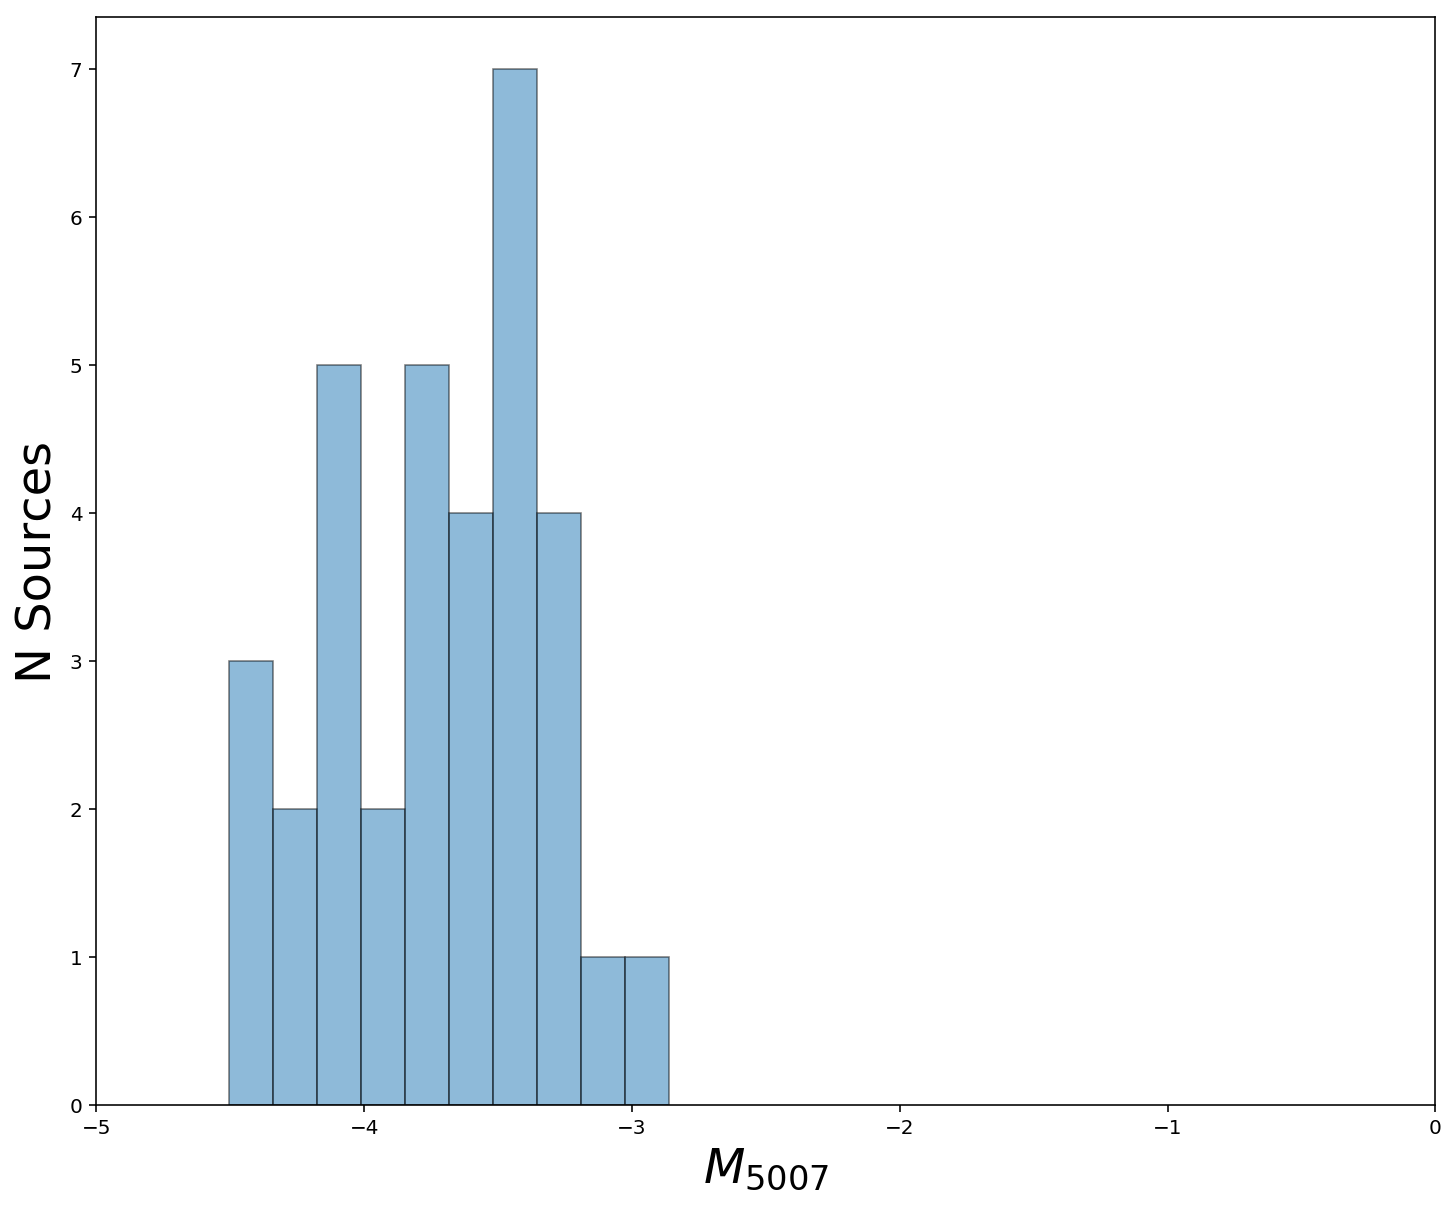

In [6]:
# useful value storage setup
total_Flux = np.zeros(len(x_PNe))
residuals_list = np.zeros(len(x_PNe))
A_OIII_list = np.zeros(len(x_PNe))
F_OIII_xy_list = np.zeros((len(x_PNe), len(PNe_spectra[0])))
M_amp_list = np.zeros(len(x_PNe))
mean_wave_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels*len(wavelength)))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros(len(x_PNe))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

model_2D = "Moffat"
#model_2D = "Gauss"
#model_2D = "Gauss_2"

for PNe_num in np.arange(0, len(x_PNe)):
    useful_stuff = []
    #run minimizer fitting routine
    results = minimize(MUSE_3D_residual, PNe_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], model_2D, PNe_num, useful_stuff), nan_policy="propagate")
    # Store values in numpy arrays
    PNe_df.loc[PNe_num, "Total Flux"] = np.sum(useful_stuff[1][1]) * 1e-20
    FWHM_list[PNe_num] = results.params["Gauss_FWHM"]
    residuals_list[PNe_num] = useful_stuff[0]
    list_of_fit_residuals[PNe_num] = results.residual
    A_OIII_list[PNe_num] = useful_stuff[1][0]
    F_OIII_xy_list[PNe_num] = useful_stuff[1][1]
    M_amp_list[PNe_num] = results.params["Amp_2D"]
    list_of_x[PNe_num] = results.params["x_0"]
    list_of_y[PNe_num] = results.params["y_0"]
    mean_wave_list[PNe_num] = results.params["mean"]
    Gauss_bkg[PNe_num] = results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = results.params["Gauss_grad"]
    #save errors
    moff_A_err[PNe_num] = results.params["Amp_2D"].stderr
    x_0_err[PNe_num] = results.params["x_0"].stderr
    y_0_err[PNe_num] = results.params["y_0"].stderr
    mean_wave_err[PNe_num] = results.params["mean"].stderr
    Gauss_bkg_err[PNe_num] = results.params["Gauss_bkg"].stderr
    Gauss_grad_err[PNe_num] = results.params["Gauss_grad"].stderr

#Apply circular aperture to total flux

Y_circ, X_circ = np.mgrid[:n_pixels, :n_pixels]
if model_2D == "Moffat":
    r = round(1.5* PNe_params["M_FWHM"])/2.
elif model_2D == "Gauss":
    r = round(1.5* PNe_params["G_FWHM"])/2.
elif model_2D == "Gauss_2":
    r = round(1.5* np.abs(PNe_params["G_FWHM_2"]))/2.
for i in np.arange(0, len(x_PNe)):
    circ_mask = (Y_circ-list_of_y[i])**2 + (X_circ-list_of_x[i])**2 > r*r
    flux_n = np.array(F_OIII_xy_list[i]) # copy list of fluxes
    flux_2D = flux_n.reshape(n_pixels, n_pixels) #reshape
    flux_2D[circ_mask==True] = 0.0 # set mask = False areas to 0.0
    PNe_df.loc[i, "Total Flux"] = np.sum(flux_2D) * 1e-20


# Signal to noise and Magnitude calculations
A_by_rN = A_OIII_list / residuals_list
PNe_df["A/rN"] = A_by_rN

de_z_means = mean_wave_list / (1 + z)

PNe_df["V (km/s)"] = (c * (de_z_means - 5007) / 5007) / 1000

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM =  5. * np.log10(21.8) + 25   # 31.63
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

#Plotting
plt.figure(1, figsize=(12,10))
info = plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
plt.xlim(-5,0)
#plt.title("Absolute Magnitude Histogram", fontsize=24)
plt.xlabel("$M_{5007}$", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
#plt.legend(fontsize=15)
#plt.savefig("Plots/FCC167/M5007 histogram.png")
bins_cens = info[1][:-1]
print(PNe_df["M 5007"].min())

In [18]:
PNe_df.nsmallest(20, "M 5007")

,PNe number,Total Flux,Flux error,V (km/s),m 5007,M 5007,M 5007 error,A/rN
21,22,4.25135e-17,NaN,-28.706667,27.188682,-4.503600,NaN,8.978599
10,11,3.94088e-17,NaN,45.419329,27.271017,-4.421266,NaN,8.509916
13,14,3.65373e-17,NaN,-99.333069,27.353159,-4.339124,NaN,5.969664
14,15,3.40353e-17,NaN,-224.023513,27.430176,-4.262106,NaN,6.358097
9,10,3.26865e-17,NaN,73.871096,27.474081,-4.218202,NaN,5.854796
6,7,3.00698e-17,NaN,17.691888,27.564672,-4.127610,NaN,7.597738
20,21,2.76436e-17,NaN,-212.995189,27.656014,-4.036268,NaN,7.115846
18,19,2.75774e-17,NaN,-34.949670,27.658617,-4.033665,NaN,6.914144
16,17,2.73639e-17,NaN,-120.192922,27.667055,-4.025227,NaN,4.569555
5,6,2.73014e-17,NaN,65.170688,27.669538,-4.022745,NaN,6.995472


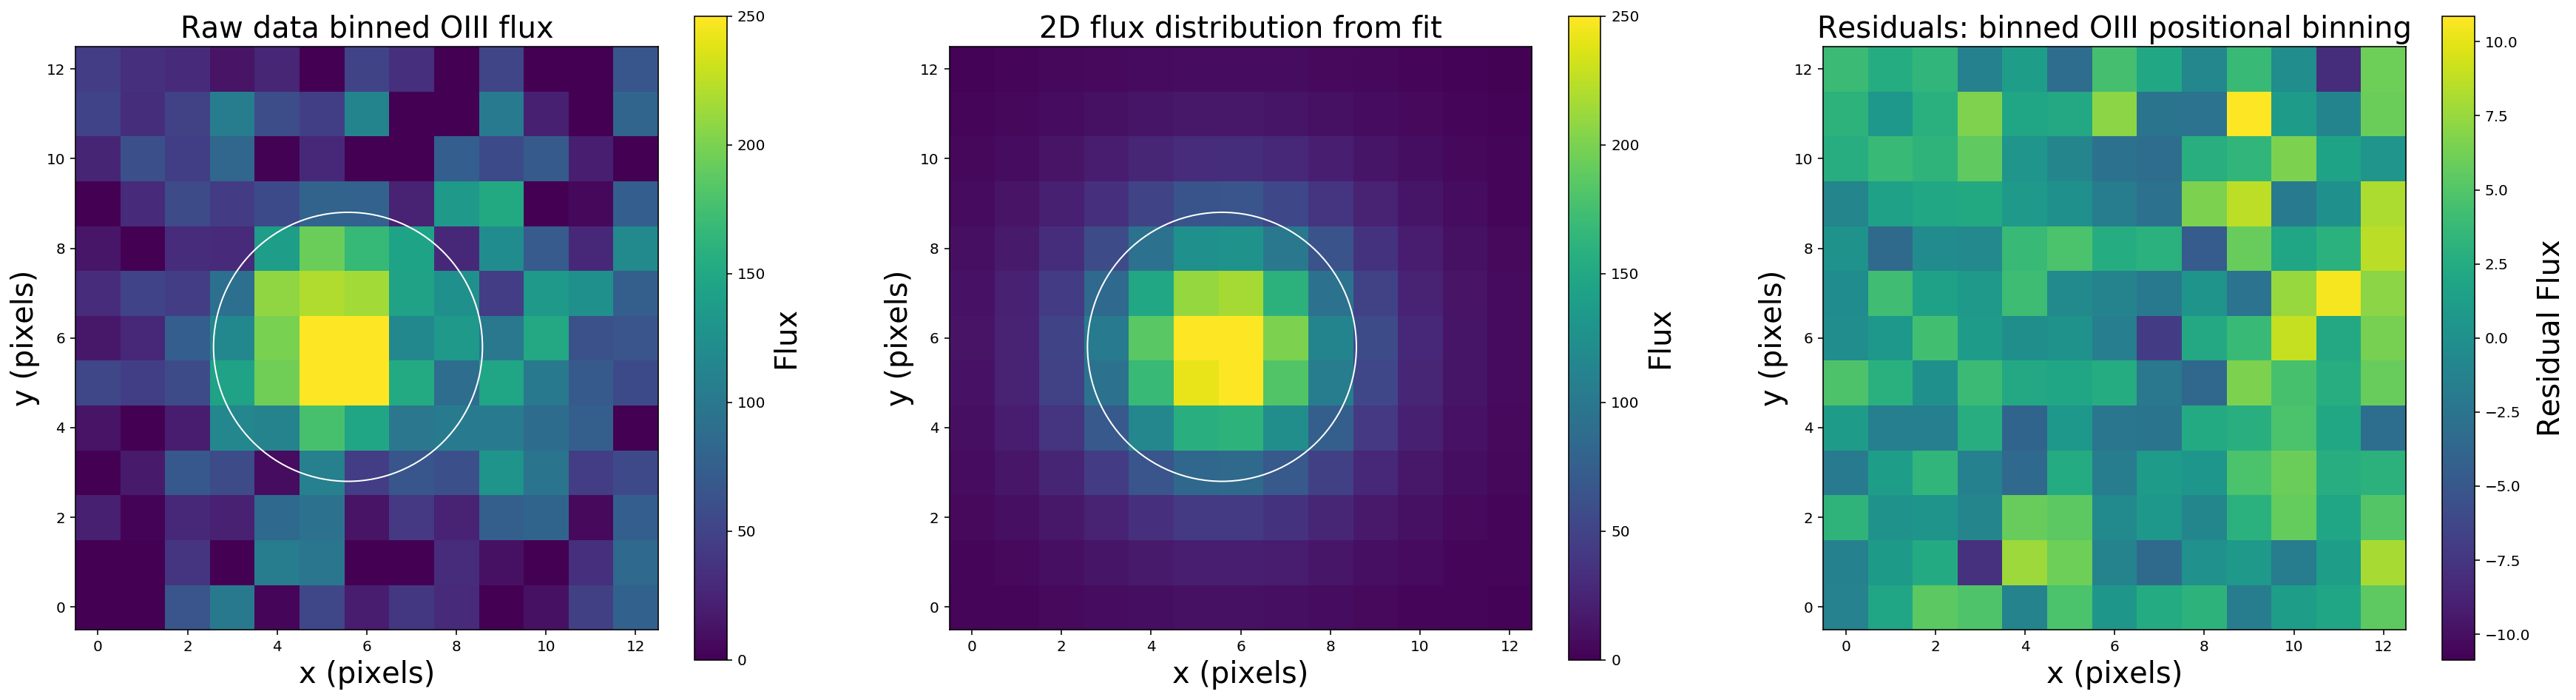

In [22]:
for n in np.arange(21,22):#,30):#, len(x_PNe)):
    PNe_n = PNe_spectra[n]
    sum_n = np.sum(PNe_n,0)
    mean_n = mean_wave_list[n]
    peak_0 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-mean_wave_list[n]))
    peak_1 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-(mean_wave_list[n]-47.93)))
    if (peak_1 is not peak_0 - 38) or (peak_1 is not peak_0 - 37):
        peak_1 = peak_0 - 38
    
    sum_peak_0 = np.sum(PNe_n[:,peak_0-3:peak_0+3],1)
    sum_peak_1 = np.sum(PNe_n[:,peak_1-2:peak_1+2],1)
    combined_peaks = sum_peak_0 + sum_peak_1
    combined_peaks_2D = combined_peaks.reshape(n_pixels, n_pixels)
    
    result_res = list_of_fit_residuals[n]
    result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
    sum_peak_res_0 = np.sum(result_res_list[:,peak_0-2:peak_0+2],1)
    sum_peak_res_1 = np.sum(result_res_list[:,peak_1-2:peak_1+2],1)
    combined_peaks_res = sum_peak_res_0 + sum_peak_res_1
    combined_peaks_res_2D = combined_peaks_res.reshape(n_pixels, n_pixels)
    plt.figure(figsize=(30,8))
    plt.subplot(1,3,1)
    plt.imshow(combined_peaks_2D, origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Raw data binned OIII flux", fontsize=20)
    ax = plt.gca()
    circ = plt.Circle((list_of_y[n],list_of_x[n]),3, color="white", fill=False)
    ax.add_artist(circ)
    cb = plt.colorbar(label="Flux")
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,2)
    plt.imshow(F_OIII_xy_list[n].reshape(n_pixels,n_pixels), origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("2D flux distribution from fit", fontsize=20)
    ax = plt.gca()
    circ = plt.Circle((list_of_y[n],list_of_x[n]),3, color="white", fill=False)
    ax.add_artist(circ)
    cb = plt.colorbar()
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,3)
    plt.imshow(combined_peaks_res_2D, origin="lower", vmin=-np.max(combined_peaks_res_2D), vmax=np.max(combined_peaks_res_2D))
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Residuals: binned OIII positional binning", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Residual Flux", fontsize=20)
    


# Completeness

In [ ]:
Noise_mask = Noise_map
Noise_mask_plot = []

fig, axs = plt.subplots(2,3, figsize=(20, 10))
axs = axs.ravel()
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()
    ratio_counter[i] = (N_data-nan_counter) / N_data
    axs[i].set_title("Absolute Magniude %s" %Abs_M[i])
    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=20)

plt.savefig("Plots/FCC170/completeness/stack.png")

In [28]:
Noise_map = np.abs(np.std(raw_data_cube, axis=2))
Y,X = np.mgrid[:y_data,:x_data]
#plt.imshow(Noise_map, origin="lower", cmap="CMRmap", vmin=0, vmax=20)

# Setup range of Absolute Magnitudes to be converted to 1D max A values
Abs_M = bins_cens #np.arange(-4.5,-1.5, 0.5)#bins_cens
dM = 5. * np.log10(21.8)+25
app_m = Abs_M + dM

total_flux = 10**((app_m + 13.74) / -2.5)
flux = total_flux / 1e-20

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

init_FWHM = PNe_params["FWHM"].value
init_beta = PNe_params["beta"].value
sum_init = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * 1.19))

max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
Noise_mask_plot = []
ratio_counter = np.zeros(len(Abs_M))
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()

    ratio_counter[i] = (N_data-nan_counter) / N_data
    Noise_mask_plot.append(Noise_mask)
    #plt.figure(figsize=(14,14))
    #plt.title("Absolute Magniude %s" %Abs_M[i])
    #plt.imshow(Noise_mask, origin="lower", vmin=0, vmax=20)
    #cb=plt.colorbar()
    #plt.savefig("Plots/FCC167/completeness/Abs M %s.png" %Abs_M[i])

#Noise_mask = Noise_map
#Noise_mask_plot = []
#
#fig, axs = plt.subplots(2,3, figsize=(20, 10))
#axs = axs.ravel()
#for i,a in enumerate(max_1D_A):
#    Noise_mask[((a / Noise_map) <2.0)] = np.nan
#    axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
#    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=30)
#
#plt.savefig("Plots/FCC167/completeness/stack.png")



C:\Users\tspri\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\tspri\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


In [125]:
ratio_counter

array([ 0.99727665,  0.996875  ,  0.99615987,  0.99534679,  0.99422022,
        0.99249608,  0.99003723,  0.9867163 ,  0.9822982 ,  0.97658699])

## PNLF fitting

In [29]:
PNLF_df = pd.DataFrame(columns=("M 5007", "PNLF", "binned_values"))
PNLF_df["M 5007"] = PNe_df["M 5007"]

diff = abs(bins_cens[0]-bins_cens[1]) / 2
bins_cens_left = bins_cens - diff

PNLF_df["binned_values"] = np.digitize(PNe_df["M 5007"], bins=bins_cens)

def PNLF_func(params, data):
    a = params["a"]
    
    # PNLF equation
    PNLF = (np.exp(0.307*PNLF_df["M 5007"])) * (1-np.exp(3*((PNLF_df["M 5007"].min() - PNLF_df["M 5007"]))))
    PNLF_df["PNLF"] = PNLF
    # Binning of PNLF values
    PNLF_sum_list = np.zeros(len(bins_cens))
    for i in np.arange(1,PNLF_df["binned_values"].max()):
        PNLF_sum_list[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
        if np.isnan(PNLF_sum_list[i-1])==True:
            PNLF_sum_list[i-1] = 0.0
    # Scale the binned values
    PNLF_scale = PNLF_sum_list * a 
    return data - PNLF_scale
                
params_PNLF = Parameters()
params_PNLF.add('a', value=5., min=0.01, max=100)

results = minimize(PNLF_func, params_PNLF, args=(info[0],), nan_policy="propagate")
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 10
    # variables        = 1
    chi-square         = 36.5847978
    reduced chi-square = 4.06497754
    Akaike info crit   = 14.9704770
    Bayesian info crit = 15.2730621
[[Variables]]
    a:  12.9214641 +/- 2.44626053 (18.93%) (init = 5)


[ 0.67495614  1.92325231  2.77162389  3.18692156  3.65230101  3.92652792
  4.32010977  4.57506705  4.80321329  5.32586856]


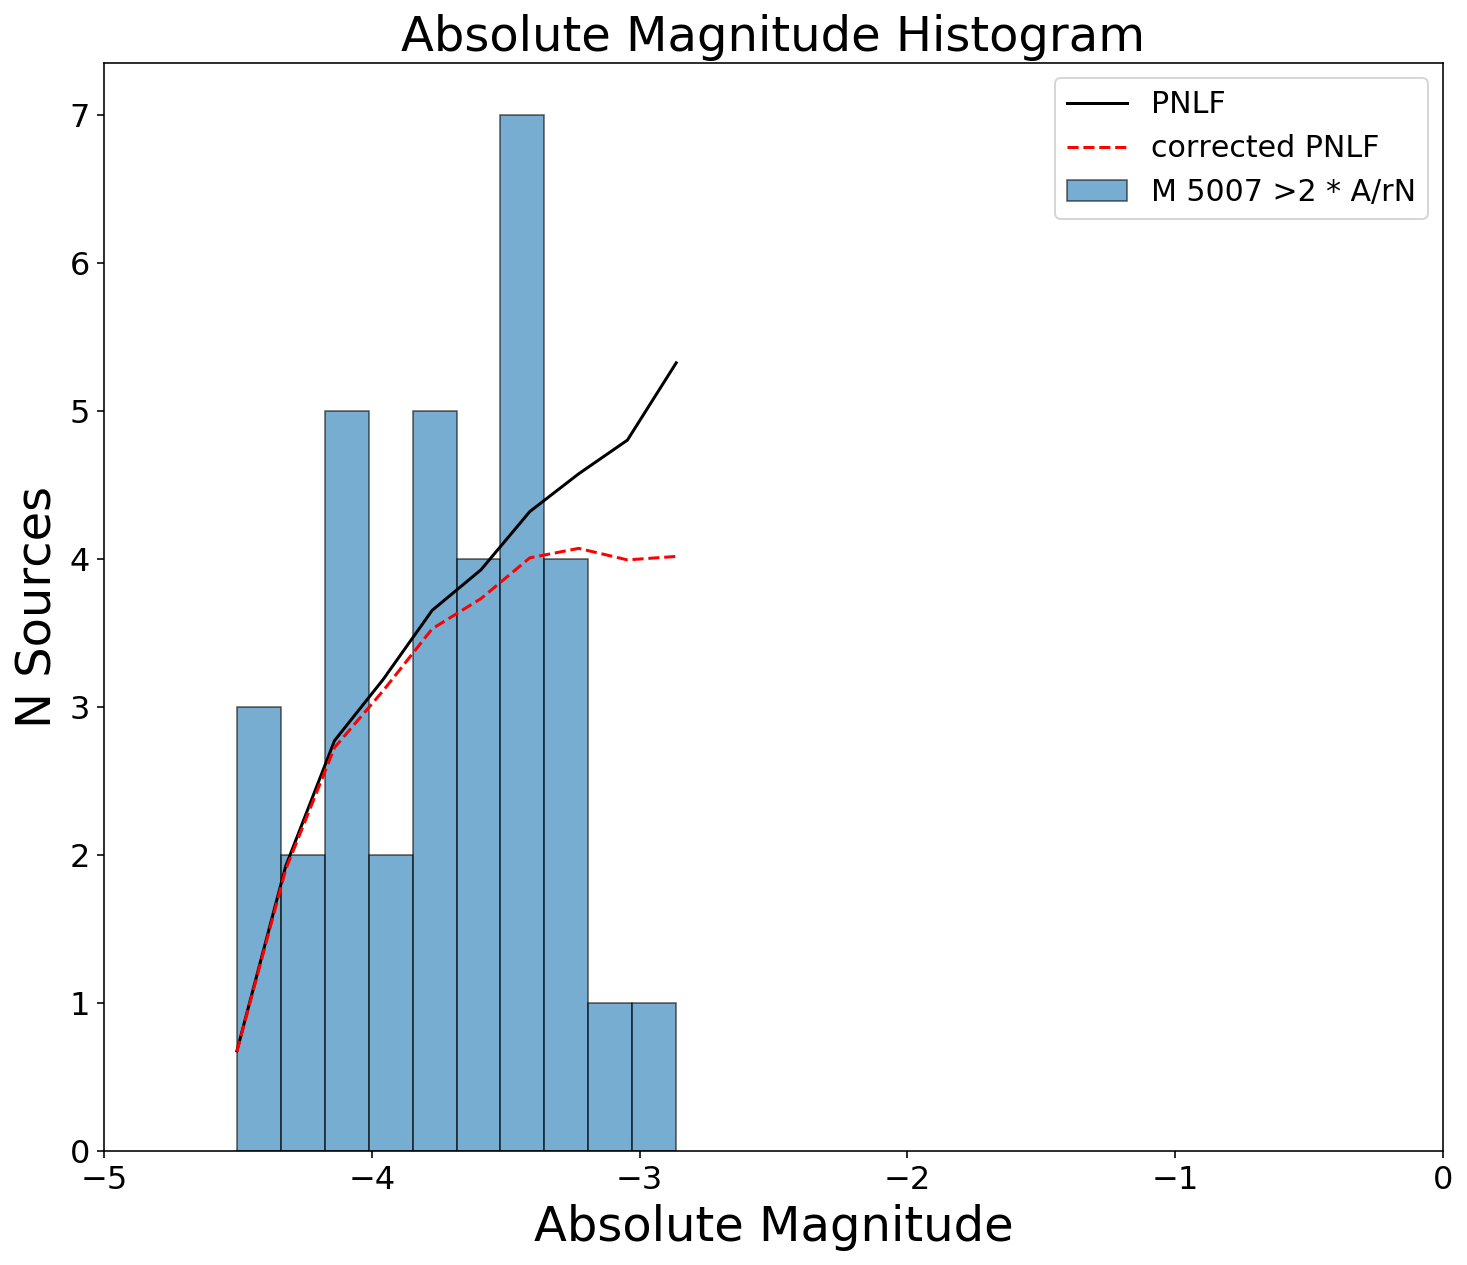

In [30]:
plt.figure(2, figsize=(12,10))
info = plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2],bins=10, edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.6)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], bins=200, edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
ax = plt.gca()
plt.xlim(-5.,0)
#plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
plt.title("Absolute Magnitude Histogram", fontsize=24)
plt.xlabel("Absolute Magnitude", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
ax.get_yticklabels()
ax.tick_params(labelsize=18)
ax.tick_params(labelsize=16)
plt.savefig("Plots/FCC170/PNLF_cen.png")

#plt.scatter(bins_cens, info[0])
PNLF = (np.exp(0.307*PNe_df["M 5007"])) * (1-np.exp(3*((PNe_df["M 5007"].min() - PNe_df["M 5007"]))))
PNLF = (PNLF * results.params["a"]) 
#plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


binned_PNLF = np.zeros(len(bins_cens))
for i in np.arange(1,len(bins_cens)+1):
    binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    
print(binned_PNLF*results.params["a"])
plt.plot(np.linspace(PNLF_df["M 5007"].min(), PNLF_df["M 5007"].max(), 10), (binned_PNLF*results.params["a"]), color="k", label="PNLF" )
plt.plot(np.linspace(PNLF_df["M 5007"].min(), PNLF_df["M 5007"].max(), 10), (binned_PNLF*results.params["a"])*ratio_counter, color="r",ls="--", label="corrected PNLF" )
plt.legend(fontsize=15)
plt.savefig("Plots/FCC170/PNLF_cen.png")

(-6, 0)

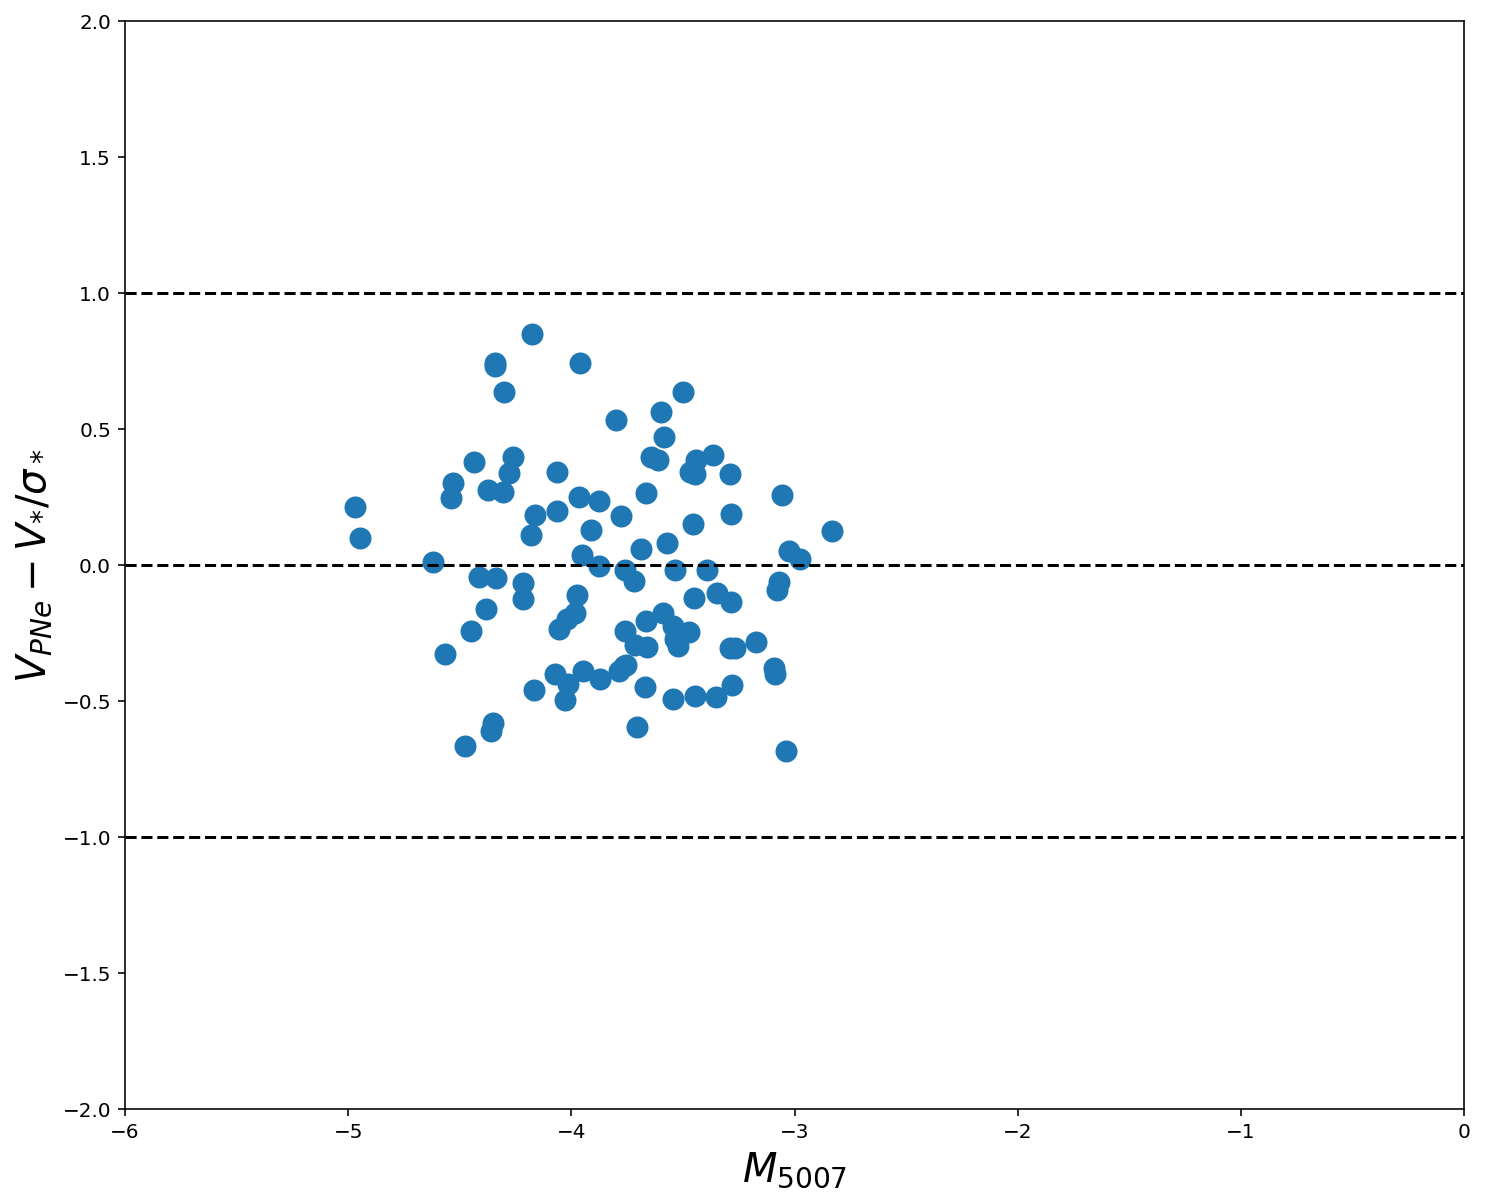

In [13]:
# Work on stellar dispersion comparison plot
stellar_vel = 0. # km/s
stellar_dis = 360. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-6,0)

## Error estimation

In [24]:
def MUSE_3D_err(params, l, x_2D, y_2D, data):
    moffat_amp = params['A_err']
    x_0 = params['x_err']
    y_0 = params['y_err']
    FWHM = params['FWHM_err']
    beta = params["beta_err"]
    mean = params["mean_err"]
    Gauss_std = params["Gauss_std"]
    Gauss_bkg = params["Gauss_bkg_err"]
    Gauss_grad = params["Gauss_grad_err"]
    
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    F_OIII_xy = moffat_amp * (1 + rr_gg)**(-beta)

    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - mean)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/3.0) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    return np.sum(F_OIII_xy * 1e-20)

high_F_list = np.zeros(len(x_PNe))
low_F_list = np.zeros(len(x_PNe))

for num in np.arange(0, len(x_PNe)):
    error_params_add = Parameters()
    error_params_add.add("A_err", value=M_amp_list[num] + moff_A_err[num], vary=False)
    error_params_add.add("x_err", value=list_of_x[num] + x_0_err[num], vary=False)
    error_params_add.add("y_err", value=list_of_y[num] + y_0_err[num], vary=False)
    error_params_add.add("FWHM_err", value=params["FWHM"].value + FWHM_in_err, vary=False)
    error_params_add.add("beta_err", value=params["beta"].value + beta_in_err, vary=False)
    error_params_add.add("mean_err", value=mean_wave_list[num] + mean_wave_err[num], vary=False)
    error_params_add.add("Gauss_std", value=1.19 + 0.0227, vary=False)
    
    error_params_minus = Parameters()
    error_params_minus.add("A_err", value=M_amp_list[num] - moff_A_err[num], vary=False)
    error_params_minus.add("x_err", value=list_of_x[num] - x_0_err[num], vary=False)
    error_params_minus.add("y_err", value=list_of_y[num] - y_0_err[num], vary=False)
    error_params_minus.add("FWHM_err", value=params["FWHM"].value - FWHM_in_err, vary=False)
    error_params_minus.add("beta_err", value=params["beta"].value - beta_in_err, vary=False)
    error_params_minus.add("mean_err", value=mean_wave_list[num] - mean_wave_err[num], vary=False)
    error_params_minus.add("Gauss_std", value=1.19 - 0.0227, vary=False)
    
    model_add = MUSE_3D_err(error_params_add, wavelength, x_fit, y_fit, PNe_spectra[num])
    high_F_list[num] = model_add
    model_minus = MUSE_3D_err(error_params_minus, wavelength, x_fit, y_fit, PNe_spectra[num])
    low_F_list[num] = model_minus

delta_F_high = high_F_list - PNe_df["Total Flux"]
delta_F_low = PNe_df["Total Flux"] - low_F_list

PNe_df["Flux error"] = np.median((delta_F_high, delta_F_low))

PNe_df["M 5007 error"] = 1.09 * (PNe_df["Flux error"] / PNe_df["Total Flux"])

## Read in 1D data for radial comparison plots, also galaxy 2d plots

In [7]:
# Pull out the 1D flux data from 1D fits to do radial comparison
gauss_1D_A = np.load("exported_data/FCC170/gauss_A_cen.npy")
A_rN_1D = np.load("exported_data/FCC170/A_rN_cen.npy")

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_xy = Flux_1D.reshape(y_data, x_data)
A_rN_1D_xy = A_rN_1D.reshape(y_data, x_data)

PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_xy, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_1D_xy, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

## Side by Side plotting of flux map, model flux map and radial flux distribution.

In [ ]:
# plot sid by side the data flux and moddelled flux array
PNe_radials = np.zeros((len(x_PNe), len(x_fit)))

for i,(x,y) in enumerate(zip(list_of_x,list_of_y)):
    PNe_radials[i]= np.sqrt((x_fit - x)**2 + (y_fit - y)**2)
k=1
for j, (ArN, flux_3D) in enumerate(zip(PNe_1D_A_rN_data, F_OIII_xy_list)):
    ArN_shape = ArN.reshape(n_pixels, n_pixels)
    flux_shape = flux_3D.reshape(n_pixels, n_pixels)
    plt.figure(figsize=(30,8))
    plt.subplot(131)
    plt.imshow(ArN_shape, origin="lower", cmap="CMRmap", vmin=1., vmax=6.)
    plt.title("1D data")
    plt.subplot(132)
    plt.imshow(flux_3D_shape, origin="lower", cmap="CMRmap", vmin=0., vmax=60.)
    plt.title("PNe number %d" %k)
    k+=1
    plt.subplot(133)
    plt.scatter(PNe_radials[j], PNe_1D_flux_data[j], c=PNe_1D_A_rN_data[j], cmap="viridis", marker=".", label="Data")
    plt.scatter(PNe_radials[j], F_OIII_xy_list[j], marker="x", label="Moffat", c="r")
    plt.title("PNe number "+ str(j+1))
    plt.axhline(y=0, c="k", ls="dashed")

## Flux and A/rN maps, with circled sources

In [1]:
plt.figure(figsize=(20,20))
plt.imshow(gauss_1D_A.reshape(y_data,x_data), origin="lower", cmap="CMRmap", vmin=0, vmax=600)
cb=plt.colorbar()
cb.set_label("A/rN",fontsize=24)
plt.xlabel("x (pixels)", fontsize=24)
plt.ylabel("y (pixels)", fontsize=24)
for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white", fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i+1, (item[0]+6, item[1]-8), color="white", size=12)
    else:
        ax.annotate(i+1, (item[0]+8, item[1]+2), color="white", size=12)
    plt.draw()

ax = plt.gca()
circ = plt.Circle((333,333),25, color="white", fill=False)
ax.add_artist(circ)
#plt.savefig("Plots/FCC170/ArN circled map.png")

NameError: name 'plt' is not defined

# MCMC routine


In [ ]:
%%time
# Using MCMC from LMFit, with emcee to fit sources, will need work done before running

m = FloatProgress(min=0, max=len(x_PNe), description="Fitting progress", )
display(m)

def lnprob(params, data, error, PNe_num):
    resid = MUSE_3D_residual(params, wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff, wavelength)
    s = params['f']
    resid *= 1 / s
    resid *= resid
    resid += np.log(2 * np.pi * s**2)
    return -0.5 * np.sum(resid)

# Use minimization results from above

MCMC_moff_amp = np.zeros(len(x_PNe))
MCMC_gamma = np.zeros(len(x_PNe))
MCMC_alpha = np.zeros(len(x_PNe))
MCMC_params = np.zeros((len(x_PNe),10))


# add a noise parameter and run MCMC for each run from results_for_MCMC
for PNe_num in np.arange(26,27):#, len(x_PNe)):
    useful_stuff = []
    run_mini = minimize(MUSE_3D_residual, params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff, wavelength), nan_policy="propagate")
    mini_result = run_mini
    #add noise parameter
    mini_result.params.add('f', value=1, min=0.001, max=2)
    mini_lnprob = Minimizer(lnprob, mini_result.params, fcn_args=(PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num))
    # Run MCMC routine
    MCMC_results = mini_lnprob.emcee(nwalkers=20, burn=400, steps=1500, thin=8, workers=3, params=mini_result.params)
    # store results
    MCMC_moff_amp[PNe_num] = MCMC_results.params["moffat_amp"]
    MCMC_gamma = MCMC_results.params["gamma"]
    MCMC_alpha = MCMC_results.params["alpha"]
    MCMC_params = MCMC_results.params
    PNe_df.loc[PNe_num, "V (km/s)"] = (c * (MCMC_results.params["mean"].value - 5006.9) / 5006.9) / 1000
    m.value += 1


    

In [25]:
sel_PNe = PNe_df.nlargest(2, "A/rN").index.values

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = error_cube[sel_PNe] 

PSF_params = Parameters()
def model_params(p, n, amp, mean):
    p.add("moffat_amp_%d" %n, value=amp, min=0.01)
    p.add("x_%d" %n, value=n_pixels/2., min=0.01, max=n_pixels)
    p.add("y_%d" %n, value=n_pixels/2., min=0.01, max=n_pixels)
    p.add("mean_%d" %n, value=mean, min=4990., max=5070.)
    p.add("gauss_bkg_%d" %n, value=0.001)
    p.add("gauss_grad_%d" %n, value=0.00001)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)    
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 
PSF_params.add("Gauss_FWHM", value=0.0, min=0.00001, max=3.0, vary=False) # LSF, instrumental resolution.

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr/PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr/PSF_results.params["beta"].value)*100) )
print("Gauss FWHM: ", PSF_results.params["Gauss_FWHM"].value, "+/-", PSF_results.params["Gauss_FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["Gauss_FWHM"].stderr/PSF_results.params["Gauss_FWHM"].value)*100) )


FWHM:  4.02006291365 +/- 0.142735308135 (3.55%)
Beta:  2.45106448798 +/- 0.342843761065 (13.99%)
Gauss FWHM:  1e-05 +/- 0 (0.00%)


In [7]:
num_psf = 20
n_brightest = PNe_df.nlargest(num_psf, "A/rN").index.values
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_sel = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.00001)


for i in np.arange(0, num_psf):
    sel_PNe = [n_brightest[i]]
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = error_cube[sel_PNe]
    PSF_params = Parameters()
    model_params(p=PSF_params, n=0, amp=200.0, mean=5035.0)
    PSF_params.add('FWHM', value=4.0, min=0.001, max=12., vary=True)
    PSF_params.add("beta", value=4.0, min=0.001, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0, min=0.0000, max=5.0, vary=False)
    A_rN_sel[i] = PNe_df.iloc[sel_PNe]["A/rN"]
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
    fitted_FWHM[i] = results.params["FWHM"].value
    fitted_beta[i] = results.params["beta"].value
    fitted_G_FWHM[i] = results.params["Gauss_FWHM"].value

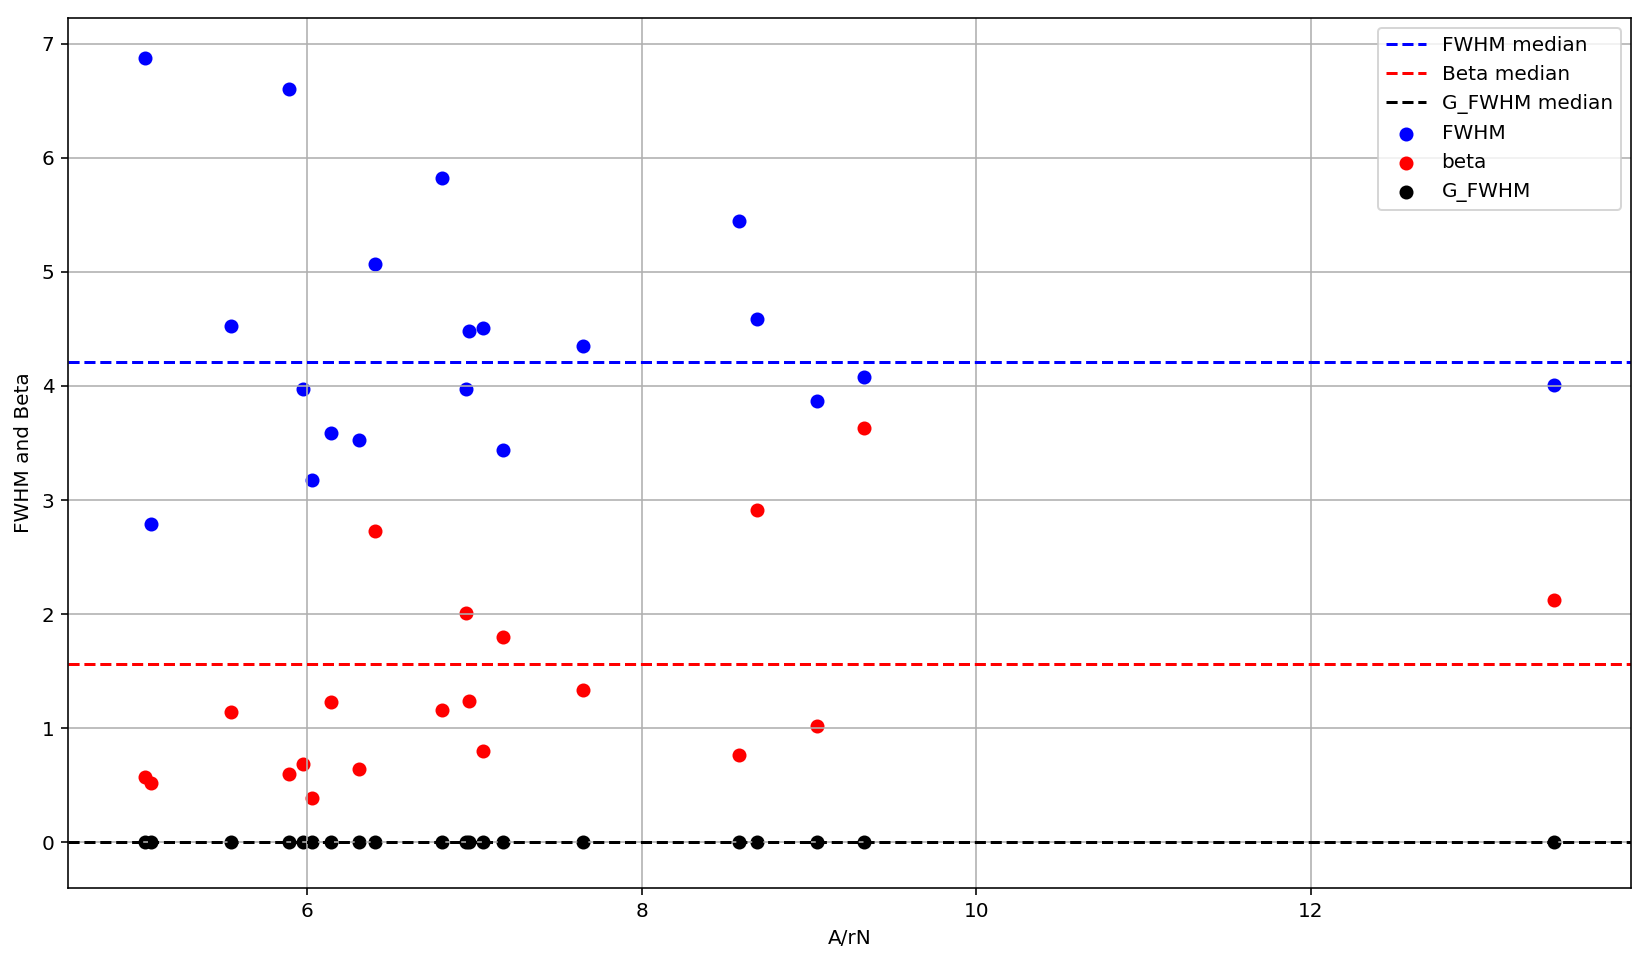

In [8]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_sel, fitted_FWHM, label="FWHM", c="blue")
plt.scatter(A_rN_sel, fitted_beta, label="beta", c="red")
plt.scatter(A_rN_sel, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()

plt.axhline(np.median(fitted_FWHM[:10]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:10]), label="Beta median", ls="dashed", c="red")
plt.axhline(np.median(fitted_G_FWHM[:10]), label="G_FWHM median", ls="dashed", c="k")

plt.legend()

In [10]:
num_psf=10
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_total = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)
fitted_moff_amp = [[]]*num_psf
fitted_x = [[]]*num_psf
fitted_y = [[]]*num_psf

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.00001)
    
for j in np.arange(0, num_psf):
    sel_PNe = PNe_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = error_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)
    PSF_params.add('FWHM', value=4.0, min=0.001, max=12., vary=True)
    PSF_params.add("beta", value=3.0, min=0.001, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0, min=0.00, max=3.0, vary=False)
    A_rN_total[j] = np.sqrt(np.sum(PNe_df.iloc[sel_PNe]["A/rN"]**2.))
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
    fitted_FWHM[j] = results.params["FWHM"].value
    fitted_beta[j] = results.params["beta"].value
    fitted_G_FWHM[j] = results.params["Gauss_FWHM"].value
    #for k in np.arange(0, len(sel_PNe)):
    #    fitted_moff_amp.append(results.params["moffat_amp_{:03d}".format(k)].value)
    #    fitted_x.append(results.params["x_{:03d}".format(k)].value)
    #    fitted_y.append(results.params["y_{:03d}".format(k)].value)

    

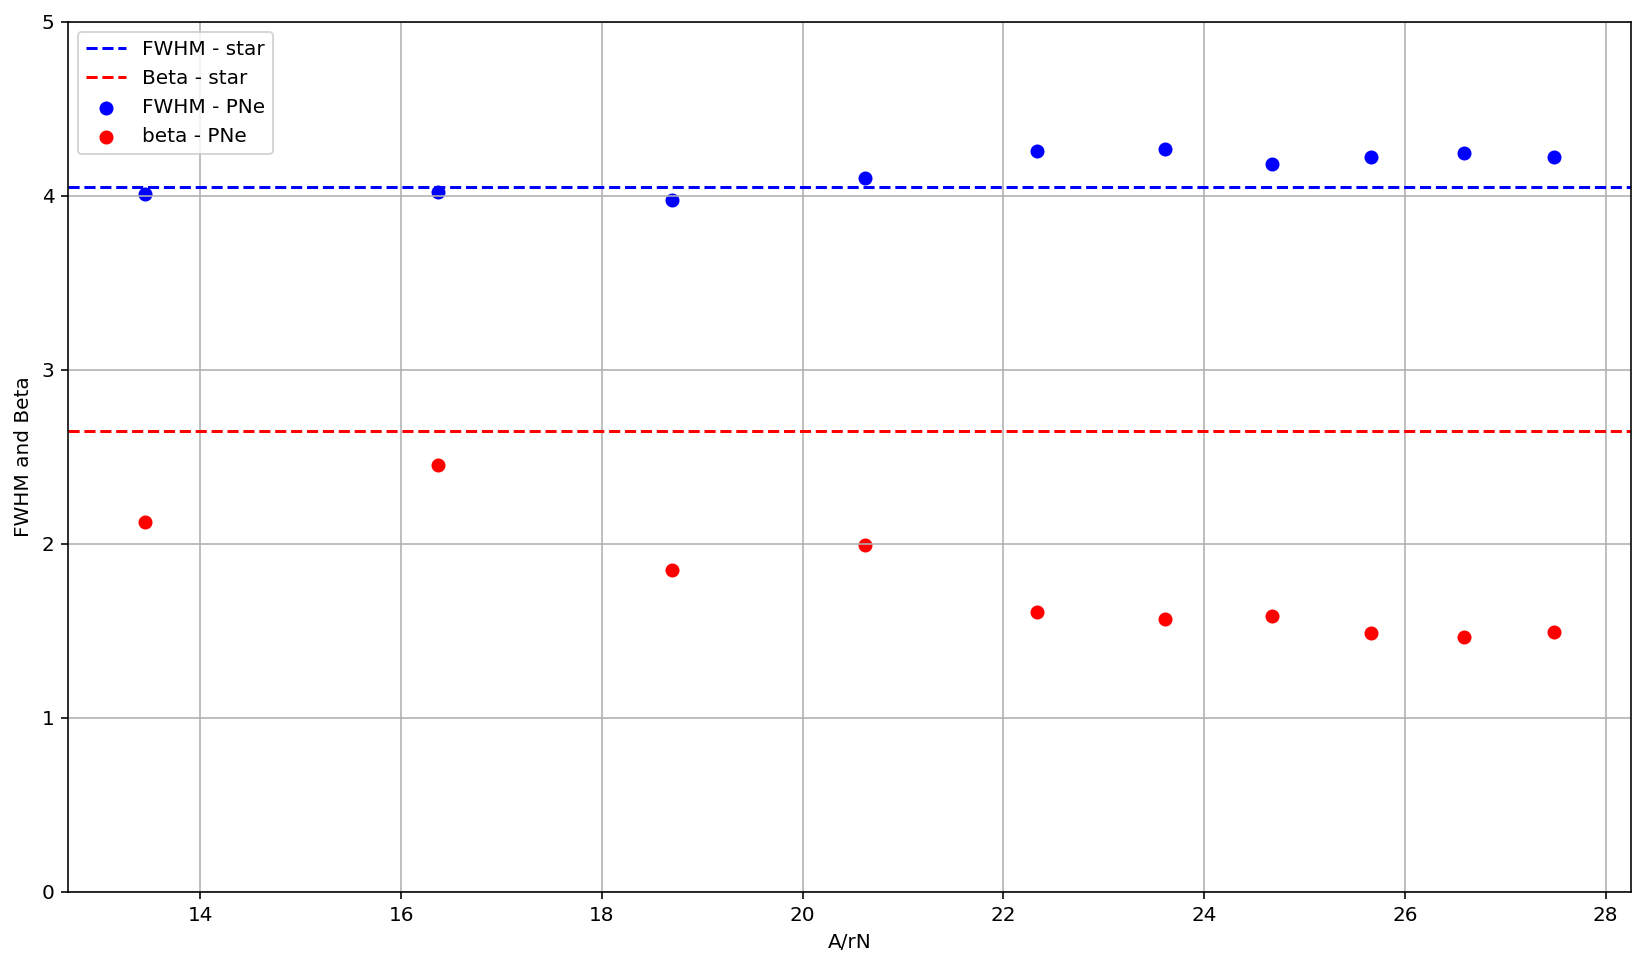

In [12]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_total, fitted_FWHM, label="FWHM - PNe", c="blue")
plt.scatter(A_rN_total, fitted_beta, label="beta - PNe", c="red")
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()
#plt.xlim(0,36)
plt.ylim(0,5.)
plt.axhline(4.049, label="FWHM - star", ls="dashed", c="blue")
plt.axhline(2.65, label="Beta - star", ls="dashed", c="red")
plt.legend()
plt.savefig("Plots/FCC170/PSF_A_rN_FWHM_beta_with_star_cen.png")

In [133]:
sel_PNe = PNe_df.nlargest(4, "A/rN").index.values

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = error_cube[sel_PNe] 

PSF_params = Parameters()
def model_params(p, n, amp, mean):
    p.add("moffat_amp_%d" %n, value=amp, min=0.001)
    p.add("x_%d" %n, value=n_pixels/2., min=0.001, max=n_pixels)
    p.add("y_%d" %n, value=n_pixels/2., min=0.001, max=n_pixels)
    p.add("mean_%d" %n, value=mean, min=4980., max=5080.)
    p.add("gauss_bkg_%d" %n, value=0.1, min=-100., max=300.)
    p.add("gauss_grad_%d" %n, value=0.001, min=-2., max=2.)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)    
    
PSF_params.add('FWHM', value=6.0, min=0.001, max=12., vary=True)
PSF_params.add("beta", value=6.0, min=0.001, max=12., vary=True) 
PSF_params.add("Gauss_std", value=1.19, vary=False) # LSF, instrumental resolution.

def lnprob(p, data, error):
    noise = p["f"]
    res = PSF_residuals(p, wavelength, x_fit, y_fit, data, error)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# add a noise parameter and run MCMC for each run from results_for_MCMC
run_mini = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
print("Initial run complete")
#add noise parameter
run_mini.params.add('f', value=1, min=0.001, max=2)
print("added f")
mini_lnprob = Minimizer(lnprob, run_mini.params, fcn_args=(selected_PNe, selected_PNe_err))
print("Minimizer run")
# Run MCMC routine
print("All go for MCMC")
MCMC_results = mini_lnprob.emcee(nwalkers=200, burn=500, steps=3000, thin=4, is_weighted=True, params=run_mini.params)

print("FWHM: " , MCMC_results.params["FWHM"].value, MCMC_results.params["FWHM"].stderr)
print("Beta: " , MCMC_results.params["beta"].value, MCMC_results.params["beta"].stderr)

Initial run complete
added f
Minimizer run
All go for MCMC
FWHM:  4.05185568796 0.120698416888
Beta:  2.39202283001 0.318743866377


# Simulations - Central pointing only

In [3]:
hdulist_sim = fits.open("FCC170_data/FCC170_OIII_center_cube.fits")
hdr_sim = hdulist_sim[0].header
raw_data_sim = hdulist_sim[0].data
y_data_sim = hdr_sim["NAXIS2"]
x_data_sim = hdr_sim["NAXIS1"]
wavelength_sim = np.exp(hdr_sim['CRVAL3']+np.arange(hdr_sim["NAXIS3"])*hdr_sim['CDELT3'])
# swap axes to y,x,wavelength
list_of_raw_data_sim = np.array(raw_data_sim).reshape(len(wavelength_sim),x_data_sim*y_data_sim)
list_of_raw_data_sim = np.swapaxes(list_of_raw_data_sim, 1, 0)
# Check for nan values
list_of_raw_data_sim[np.isnan(list_of_raw_data_sim)]=0.001
# retrieve x and y data shape lengths

#raw_data_shape = raw_data.reshape(y_data,x_data, len(full_wavelength))

Flux_data_shape_sim = list_of_raw_data_sim.reshape(y_data_sim, x_data_sim, len(wavelength_sim))

n_pixels_sim=13
X_AOI_sim, Y_AOI_sim = np.mgrid[:n_pixels_sim,:n_pixels_sim]

coordinates_sim = [(n,m) for n in range(n_pixels_sim) for m in range(n_pixels_sim)]

x_fit_sim = np.array([item[0] for item in coordinates_sim])
y_fit_sim = np.array([item[1] for item in coordinates_sim])

# Retrieve the respective spectra for each PNe source

flatten = lambda l: [item for sublist in l for item in sublist]
   
def extractor(x, y, n_pix, data, wave):
    x = round(x)
    y = round(y)
    if n_pix %2 == 1.0:
        offset = (0.5*n_pix)+0.5
    elif n_pix %2 == 0.0:
        offset = (0.5*n_pix)
    left_x = x - offset
    right_x = left_x + n_pix
    top_y = y - offset
    bottom_y = top_y + n_pix
    # select the spectra of interest
    extract_from_data = data[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    output = extract_from_data.reshape(n_pix**2, len(wave))
    
    return output

noise_cube = np.array(extractor(265, 45, n_pixels_sim, Flux_data_shape_sim, wavelength_sim))

In [4]:
def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit_sim - x_0)**2 + (y_fit_sim - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) + (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

Abs_M_list = np.arange(-4.7, -2.0, 0.02)
dM = 5. * np.log10(21.78) + 25
# m_5007
app_m_list = Abs_M_list + dM
# F_5007, total
total_flux_list = 10**((app_m_list + 13.74) / -2.5)
flux = total_flux_list / 1e-20

n_PNe = len(flux)
print("Number of PNe:", n_PNe)
print("Total number of simulations to run:", n_PNe)

init_FWHM = 3.9
init_beta = 2.5
#find starting amplitude
sum_init = np.sum(moffat(1, n_pixels_sim/2, n_pixels_sim/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Moffat arrays
test_PNe_moffat = np.array([moffat(A, n_pixels_sim/2, n_pixels_sim/2, init_FWHM, init_beta) for A in input_moff_A])

# Amplitude arrays
Amp_x_y = ((test_PNe_moffat) / (np.sqrt(2*np.pi) * 1.19))

# Gaussian cubes
sim_g_cubes = np.zeros((n_PNe, n_pixels_sim**2 ,len(wavelength_sim)))
for i, PNe in enumerate(Amp_x_y):
    sim_g_cubes[i] = np.array([gaussian(wavelength_sim, A, 5032., 1.19, 0.0, 0.0) for A in PNe])

# Generate simulation cubes = gaussian cubes + noise cube
sim_cubes = np.zeros((n_PNe, n_pixels_sim**2, len(wavelength_sim)))
for i in np.arange(0, n_PNe):
        sim_cubes[i] = sim_g_cubes[i] + noise_cube 

# Error cubes
error_cube_sim = np.zeros((n_PNe, n_pixels_sim**2, len(wavelength_sim)))
for PNe_num in np.arange(0, n_PNe):
    list_of_std_sim = [np.abs(np.std(spec)) for spec in sim_cubes[PNe_num]]
    error_cube_sim[PNe_num] = [np.repeat(list_of_std_sim[i], len(wavelength_sim)) for i in np.arange(0,len(list_of_std_sim))]


Number of PNe: 135
Total number of simulations to run: 135


In [5]:
sim_params = Parameters()
sim_params.add('moffat_amp', value=100.)
sim_params.add('x_0', value=(n_pixels_sim/2), min=0.1, max=n_pixels_sim)
sim_params.add('y_0', value=(n_pixels_sim/2), min=0.1, max=n_pixels_sim)
sim_params.add('FWHM', value=3.0, min=0.01, max=9., vary=True)
sim_params.add("beta", value=2.0, min=0.01, max=9., vary=True)
sim_params.add("mean", value=5033., min=4990, max=5080)
sim_params.add("Gauss_FWHM", value=0.0, min=0.01, max=3.0, vary=False) # LSF, instrumental resolution.
sim_params.add("Gauss_bkg",  value=0.00001,)
sim_params.add("Gauss_grad", value=0.000001,)

#1.5381324630998943
#3.8455093323220817

fitted_FWHM = np.zeros(n_PNe)
fitted_beta = np.zeros(n_PNe)
fitted_useful_stuff = []

for i in np.arange(0, n_PNe):
    useful_stuff_sim = []
    sim_results = minimize(MUSE_3D_residual, sim_params, args=(wavelength_sim, x_fit_sim, y_fit_sim, sim_cubes[i], error_cube_sim[i], i, useful_stuff_sim), nan_policy="propagate")
    fitted_FWHM[i] = sim_results.params["FWHM"].value
    fitted_beta[i] = sim_results.params["beta"].value
    fitted_useful_stuff.append(useful_stuff_sim)



In [7]:
fitted_flux = np.array([np.sum(item[0][2])*1e-20 for item in fitted_useful_stuff])
fitted_rN = np.array([item[0][0] for item in fitted_useful_stuff])
fitted_moff_A = np.array([item[0][1] for item in fitted_useful_stuff])

fitted_A_rN = fitted_moff_A / fitted_rN

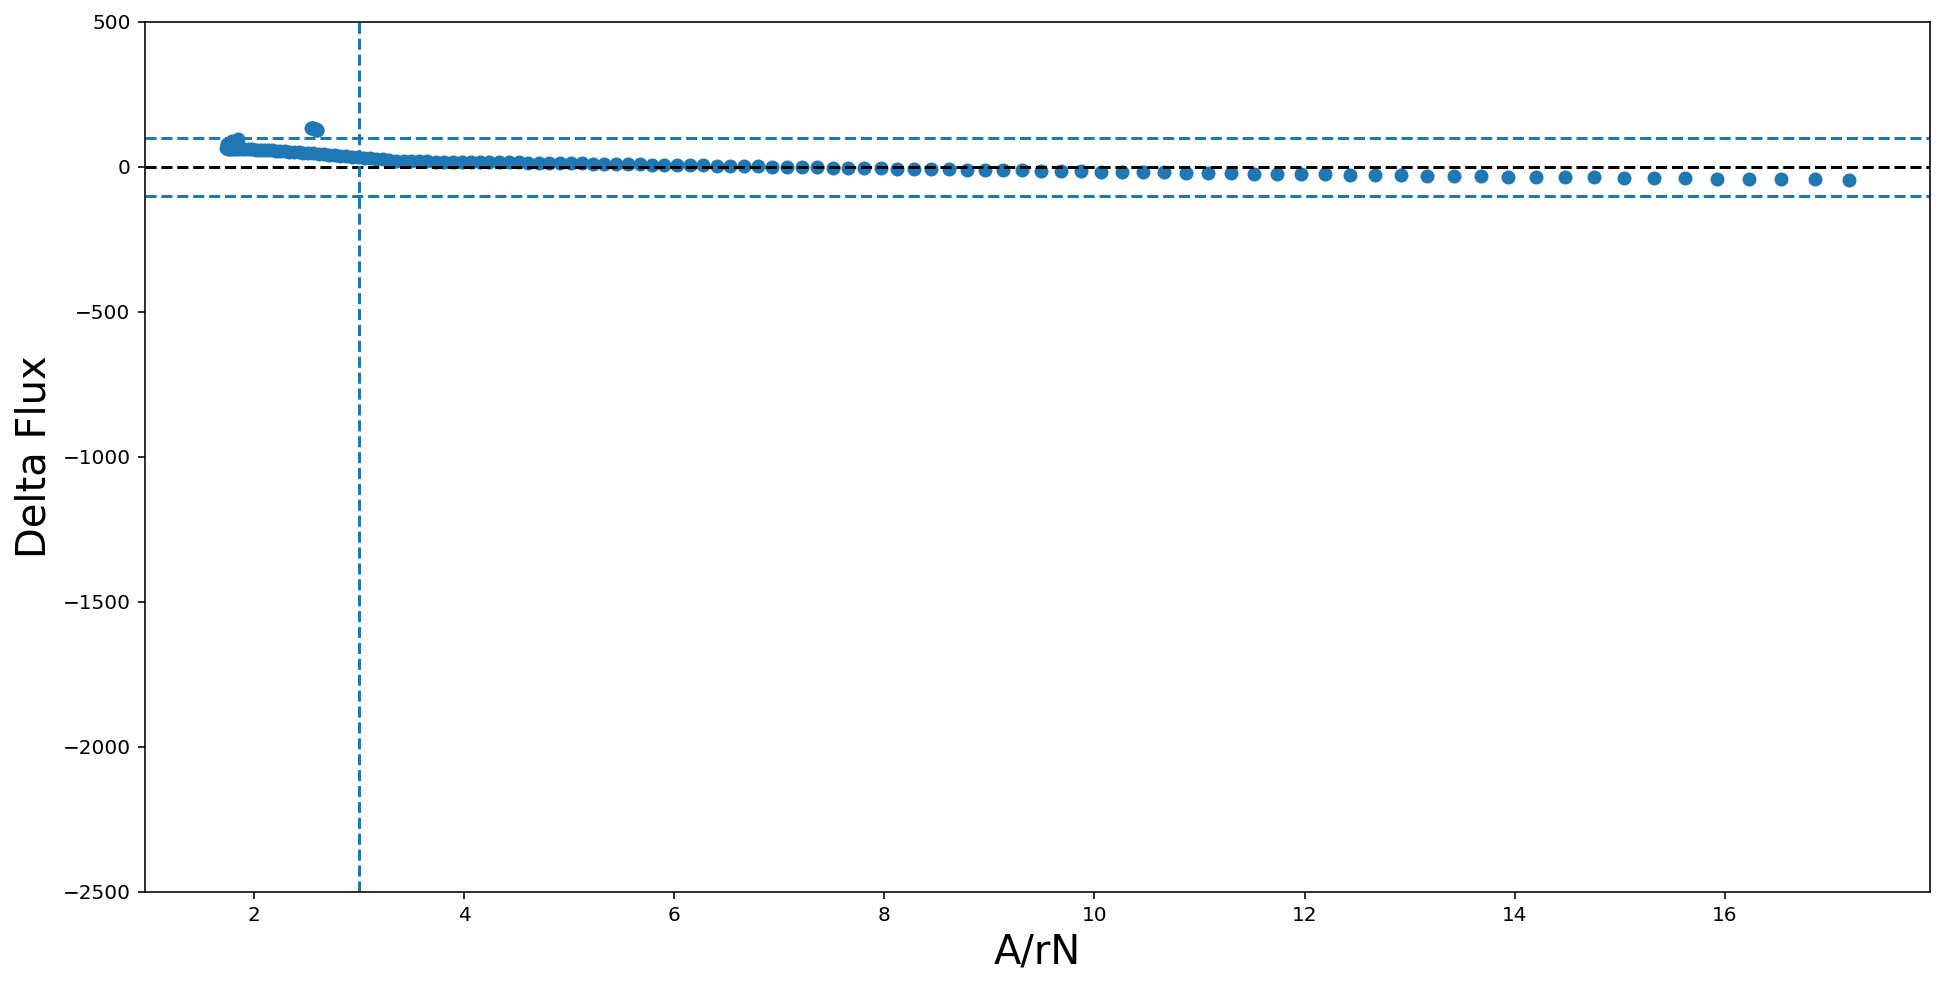

In [8]:
Flux_diff = (fitted_flux - total_flux_list) / 1e-20
plt.figure(figsize=(16,8))
plt.axhline(0, c="k", ls="--")
plt.scatter(fitted_A_rN, Flux_diff)
plt.ylabel("Delta Flux", fontsize="20")
plt.xlabel("A/rN", fontsize="20")
plt.ylim(-2500,500)
plt.axhline(100, ls="--")
plt.axhline(-100, ls="--")
plt.axvline(3, ls="--")
#plt.savefig("Plots/FCC167/delta Flux sim vs. A_rN.png")

Text(0.5,0,'A/rN')

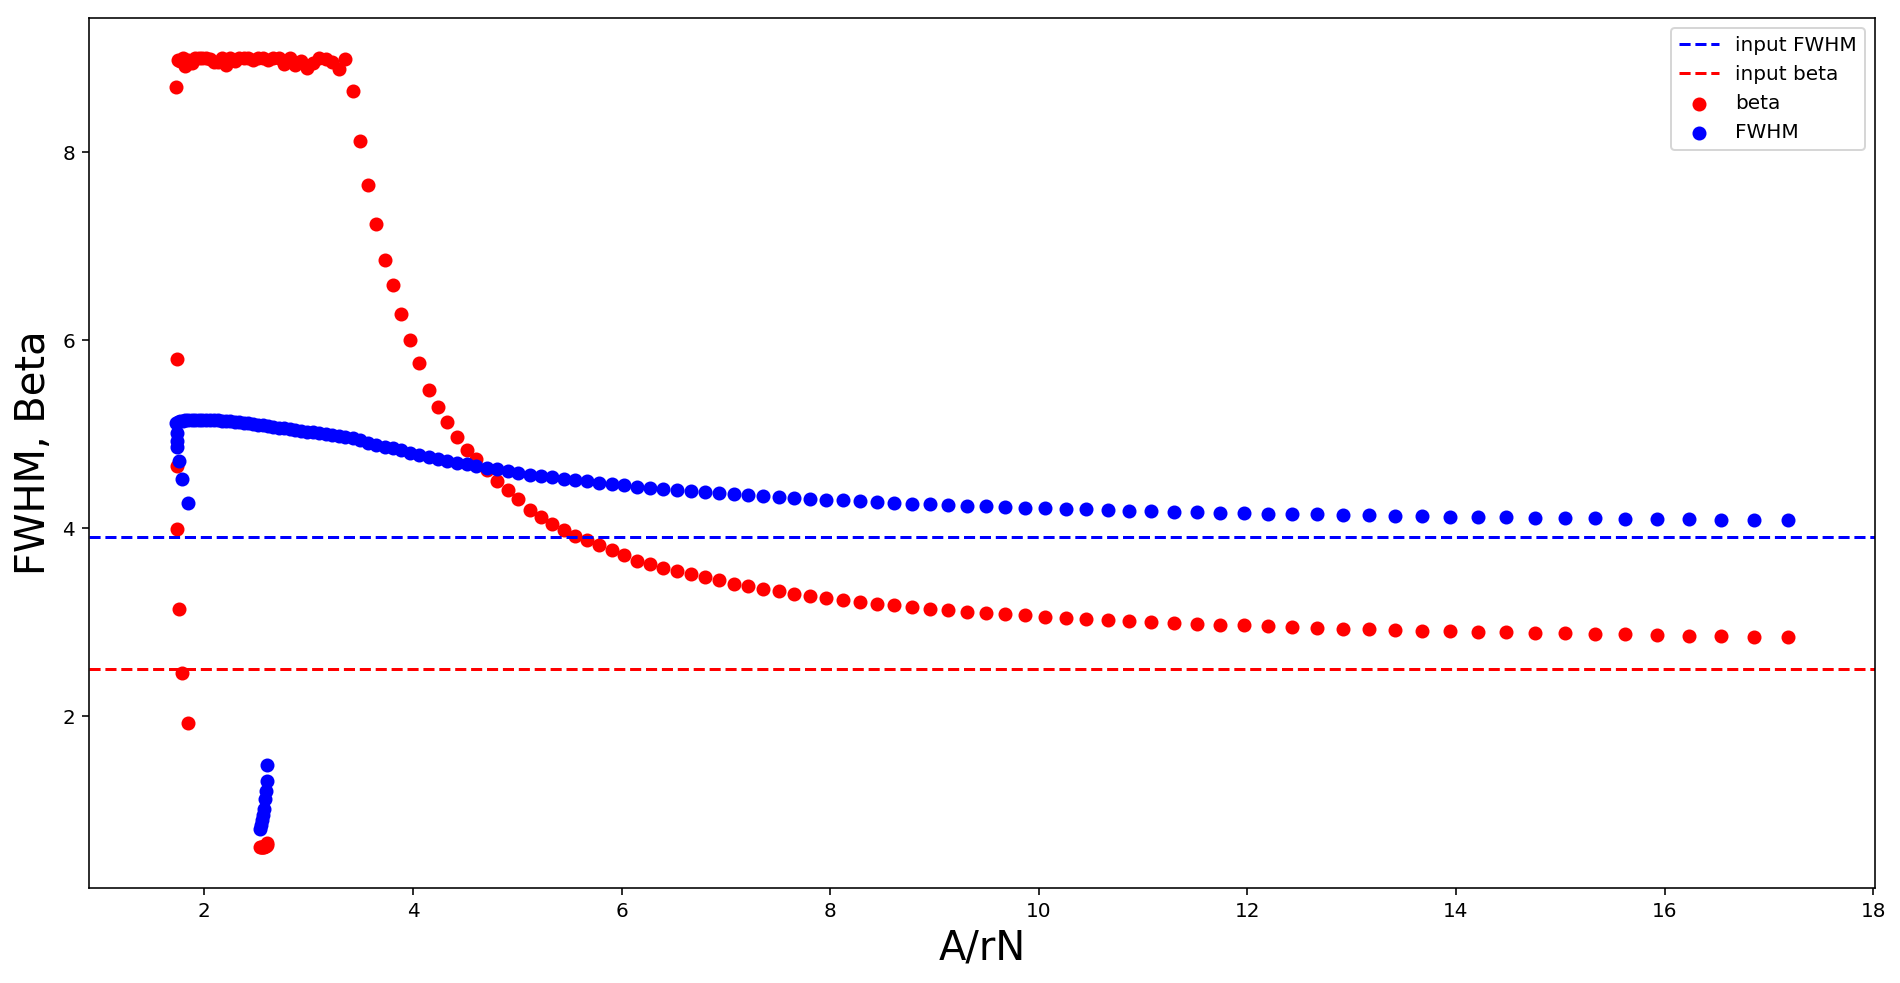

In [9]:
plt.figure(figsize=(16,8))
plt.scatter(fitted_A_rN, fitted_beta, c="r", label="beta")
plt.scatter(fitted_A_rN, fitted_FWHM, c="b", label="FWHM")
plt.axhline(init_FWHM, c="b", ls="--", label="input FWHM")
plt.axhline(init_beta, c="r", ls="--", label="input beta")
plt.legend()
plt.ylabel("FWHM, Beta", fontsize="20")
plt.xlabel("A/rN", fontsize="20")
#plt.savefig("Plots/FCC167/FWHM and beta vs A_rN.png")

In [109]:
np.median(fitted_beta[0])

1.6233206008299392

In [112]:
testing_df = pd.DataFrame(columns=("PNe number", "A/rN", "fitted FWHM", "fitted beta"))
testing_df["PNe number"] = np.arange(1,len(fitted_FWHM)+1)
testing_df["A/rN"] = fitted_A_rN
testing_df["fitted FWHM"] = fitted_FWHM
testing_df["fitted beta"] = fitted_beta


In [122]:
display(testing_df["fitted beta"].loc[testing_df["A/rN"]>=10.].median())
display(testing_df["fitted FWHM"].loc[testing_df["A/rN"]>=10.].median())


1.5381324630998943

3.8455093323220817